IMPORT NECCESSARY LIBRARIES

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pdfplumber
from sklearn.metrics.pairwise import cosine_similarity

LOAD THE DATASET

In [3]:
# Open the PDF and extract text
with pdfplumber.open('Ecommerce_Recommendation_Dataset.pdf') as pdf:
    pages = pdf.pages
    data = []
    for page in pages:
        tables = page.extract_tables()
        for table in tables:
            data.extend(table)

# Convert extracted data to a DataFrame
data = pd.DataFrame(data[1:], columns=data[0])  # Assuming the first row is the header

In [4]:
data.head()

,UserID,UserAge,Gender,ProductID,ProductCategory,PurchaseAmount,PurchaseDate,Rating
0,1,25,Male,101,Electronics,20,2023-01-01 00:00:00,5
1,2,30,Female,102,Clothing,40,2023-01-02 00:00:00,4
2,3,35,Male,103,Books,60,2023-01-03 00:00:00,3
3,4,40,Female,104,Home,80,2023-01-04 00:00:00,4
4,5,45,Male,105,Toys,100,2023-01-05 00:00:00,5


DATA PRPEROCESSING

In [5]:
# Convert PurchaseDate to datetime
data['PurchaseDate'] = pd.to_datetime(data['PurchaseDate'])

In [6]:
data.isnull().sum()

UserID             0
UserAge            0
Gender             0
ProductID          0
ProductCategory    0
PurchaseAmount     0
PurchaseDate       0
Rating             0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   UserID           50 non-null     object        
 1   UserAge          50 non-null     object        
 2   Gender           50 non-null     object        
 3   ProductID        50 non-null     object        
 4   ProductCategory  50 non-null     object        
 5   PurchaseAmount   50 non-null     object        
 6   PurchaseDate     50 non-null     datetime64[ns]
 7   Rating           50 non-null     object        
dtypes: datetime64[ns](1), object(7)
memory usage: 3.2+ KB


PREPROCESSING THE DATA

In [11]:
# Convert object columns to numeric where applicable
columns_to_convert = ['UserID', 'UserAge', 'PurchaseAmount', 'Rating', 'ProductID']
for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Handle missing values after conversion (if any)
data.fillna(0, inplace=True)

# Encode categorical variables (e.g., Gender and ProductCategory)
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['ProductCategory'] = data['ProductCategory'].astype('category').cat.codes

# Add new features
# 1. User's average spend
data['AverageSpendPerUser'] = data.groupby('UserID')['PurchaseAmount'].transform('mean')

# 2. Product popularity (sum of purchase amounts for each product)
data['ProductPopularity'] = data.groupby('ProductID')['PurchaseAmount'].transform('sum')

# 3. Days since last purchase
data['DaysSinceLastPurchase'] = (data['PurchaseDate'].max() - data['PurchaseDate']).dt.days

# 4. User's total purchases
data['UserTotalPurchases'] = data.groupby('UserID')['PurchaseAmount'].transform('sum')

# 5. User's purchase frequency
purchase_counts = data.groupby('UserID').size()
data['PurchaseFrequency'] = data['UserID'].map(purchase_counts)

# Display the updated dataset
data.head()

,UserID,UserAge,Gender,ProductID,ProductCategory,PurchaseAmount,PurchaseDate,Rating,AverageSpendPerUser,ProductPopularity,DaysSinceLastPurchase,UserTotalPurchases,PurchaseFrequency
0,1,25,NaN,101,2,20,2023-01-01,5,20.0,200,49,20,1
1,2,30,NaN,102,1,40,2023-01-02,4,40.0,400,48,40,1
2,3,35,NaN,103,0,60,2023-01-03,3,60.0,600,47,60,1
3,4,40,NaN,104,3,80,2023-01-04,4,80.0,800,46,80,1
4,5,45,NaN,105,4,100,2023-01-05,5,100.0,1000,45,100,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   UserID                 50 non-null     int64         
 1   UserAge                50 non-null     int64         
 2   Gender                 0 non-null      float64       
 3   ProductID              50 non-null     int64         
 4   ProductCategory        50 non-null     int8          
 5   PurchaseAmount         50 non-null     int64         
 6   PurchaseDate           50 non-null     datetime64[ns]
 7   Rating                 50 non-null     int64         
 8   AverageSpendPerUser    50 non-null     float64       
 9   ProductPopularity      50 non-null     int64         
 10  DaysSinceLastPurchase  50 non-null     int64         
 11  UserTotalPurchases     50 non-null     int64         
 12  PurchaseFrequency      50 non-null     int64         
dtypes: date

    EXPLORATORY DATA ANALYSIS

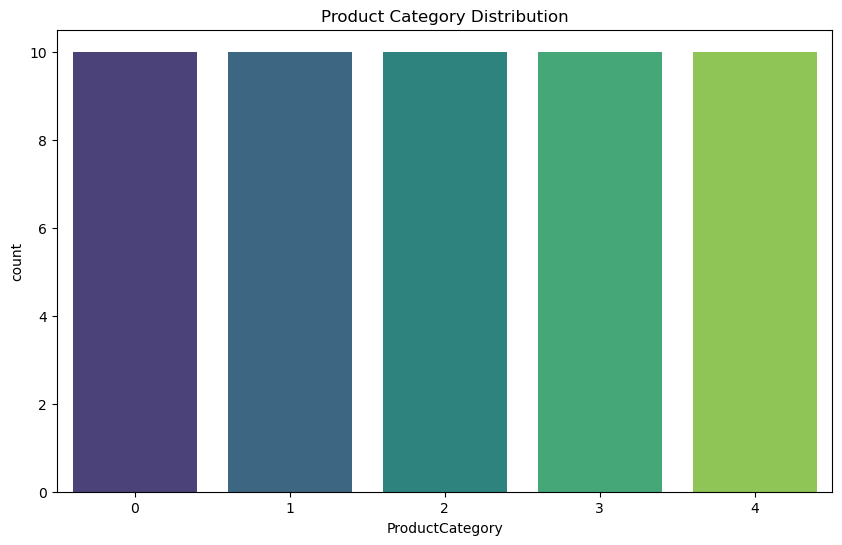

In [13]:
# Visualize purchase trends
plt.figure(figsize=(10, 6))
sns.countplot(x='ProductCategory', data=data, palette='viridis')
plt.title('Product Category Distribution')
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_6132\36268895.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


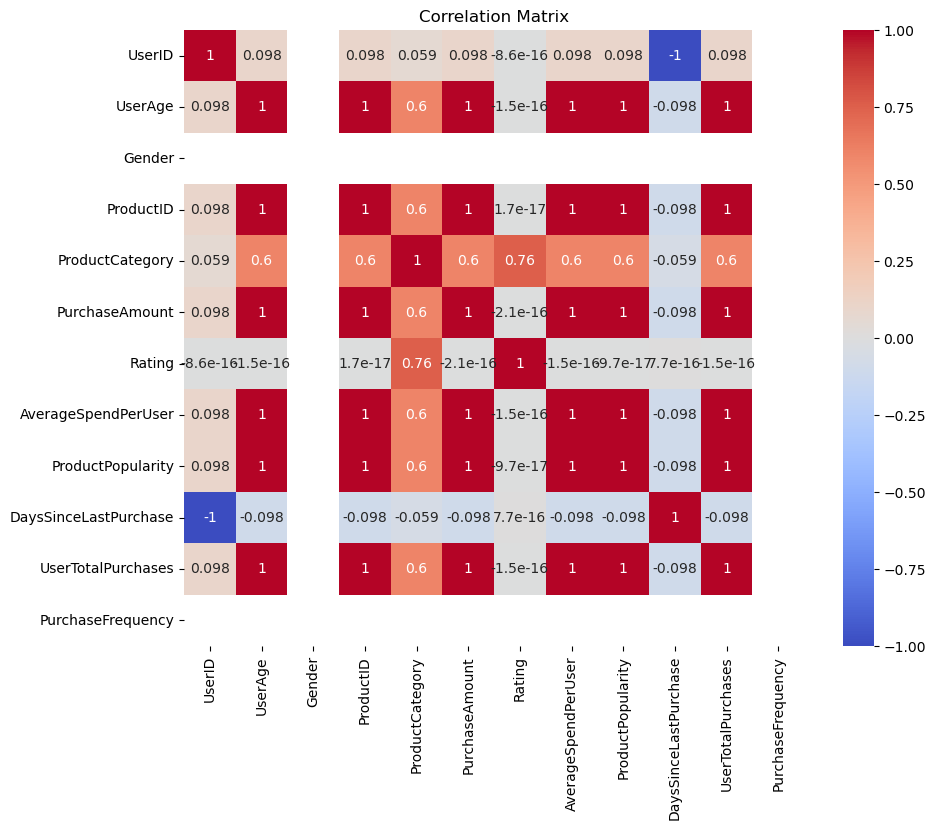

In [14]:
# Correlation heatmap
correlation = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

COLLABORATIVE FILTERING USING SVD

In [25]:
# Create a user-item matrix
user_item_matrix = data.pivot_table(index='UserID', columns='ProductID', values='Rating').fillna(0)

# Perform Singular Value Decomposition (SVD)
n_features = user_item_matrix.shape[1]
n_components = min(10, n_features)  # Set n_components based on the number of features

svd = TruncatedSVD(n_components=n_components, random_state=42)
matrix_svd = svd.fit_transform(user_item_matrix)

# Define a function to recommend products for a user
def recommend_products(user_id, n_recommendations=5):
    user_index = user_item_matrix.index.get_loc(user_id)
    user_scores = matrix_svd[user_index]
    recommendations = np.argsort(-user_scores)[:n_recommendations]
    product_ids = user_item_matrix.columns[recommendations]
    return product_ids

CONTENT-BASED FILTERING

In [26]:
# Prepare product attributes (e.g., ProductCategory and ProductID)
product_features = data[['ProductID', 'ProductCategory', 'PurchaseAmount']].drop_duplicates()

# Normalize the features
scaler = MinMaxScaler()
product_features[['PurchaseAmount']] = scaler.fit_transform(product_features[['PurchaseAmount']])

# Compute cosine similarity between products
similarity_matrix = cosine_similarity(product_features[['ProductCategory', 'PurchaseAmount']], product_features[['ProductCategory', 'PurchaseAmount']])

# Function to recommend similar products based on content
def content_based_recommendations(product_id, n_recommendations=5):
    product_index = product_features[product_features['ProductID'] == product_id].index[0]
    similarity_scores = similarity_matrix[product_index]
    similar_indices = np.argsort(-similarity_scores)[:n_recommendations]
    similar_products = product_features.iloc[similar_indices]
    return similar_products[['ProductID', 'ProductCategory', 'PurchaseAmount']]


HYBRID MODEL

In [28]:
# Hybrid Recommendation: Combine SVD-based and Content-based recommendations
def hybrid_recommendations(user_id, product_id, n_recommendations=5):
    # Collaborative filtering recommendation
    collaborative_recommendations = recommend_products(user_id, n_recommendations)
    
    # Content-based recommendation
    content_recommendations = content_based_recommendations(product_id, n_recommendations)
    
    # Combine both recommendations (take the union or blend them based on user needs)
    combined_recommendations = list(set(collaborative_recommendations) | set(content_recommendations['ProductID']))
    
    return combined_recommendations[:n_recommendations]

# Example hybrid recommendation for User 1 and Product 101
print("Hybrid Recommendations for User 1 and Product 101:", hybrid_recommendations(user_id=1, product_id=101))

Hybrid Recommendations for User 1 and Product 101: [101, 102, 103, 104, 105]


TRAIN/TEST SPLIT & EVALUATION

In [29]:
# Split data into training and testing sets (80/20 split)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create training and test matrices
train_matrix = train_data.pivot_table(index='UserID', columns='ProductID', values='Rating').fillna(0)
test_matrix = test_data.pivot_table(index='UserID', columns='ProductID', values='Rating').fillna(0)

GENERATING PREDICTION FOR TEST SET

In [30]:
# Initialize a list to store the predicted ratings
test_predictions = []

# Loop through each row in the test set
for _, row in test_data.iterrows():
    user_id = row['UserID']
    # Predict ratings for the user using collaborative filtering (e.g., based on SVD)
    recommended_product = recommend_products(user_id)[0]  # Recommend top product
    test_predictions.append(recommended_product)

# Flatten the predicted ratings into a numpy array
test_predicted_ratings = np.array([recommend_products(user_id)[0] for user_id in test_data['UserID']]).flatten()


ALIGN THE PREDICTED AND ACTUAL RATINGS

In [32]:
# Extract the actual ratings from the test set
test_actual_ratings = test_data['Rating'].values.flatten()  # Convert to a flat array

# Ensure the predicted ratings match the actual ratings in length
test_predicted_ratings = test_predicted_ratings[:len(test_actual_ratings)]

In [ ]:
# Evaluate Mean Squared Error (MSE)
mse = mean_squared_error(test_actual_ratings, test_predicted_ratings)
print(f'Mean Squared Error (MSE): {mse}')

# Evaluate Precision and Recall (assuming binary relevance: ratings >= 4 are relevant)
from sklearn.metrics import precision_score, recall_score

# Convert ratings into binary relevance (1 for relevant, 0 for irrelevant)
threshold = 4
binary_actual_ratings = (test_actual_ratings >= threshold).astype(int)
binary_predicted_ratings = (test_predicted_ratings >= threshold).astype(int)

# Calculate Precision and Recall
precision = precision_score(binary_actual_ratings, binary_predicted_ratings)
recall = recall_score(binary_actual_ratings, binary_predicted_ratings)
accuracy = accuracy_score(binary_actual_ratings, binary_predicted_ratings)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy:{accuracy}')

Mean Squared Error (MSE): 9726.8
Precision: 0.8
Recall: 1.0
Accuracy:0.8
